# Detection of Master Regulators on a dummy example

This vignette displays some examples of what can be achieved using **NORDic (version 2.2.1)** in order to detect master regulators.

## Installation

In [1]:
import NORDic

## Detection of master regulators

**NORDic PMR** exploits a Boolean network in order to find master regulators. Its approach is based on influence maximization. For more information about the method, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):


> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.


The input network does not need to be an output of **NORDic NI**, and the corresponding .BNET file can be independenty generated. We illustrate this by feeding to **NORDic PMR** a dummy example.

In [2]:
from subprocess import call as sbcall
save_folder="MODELS/dummy/"
sbcall("mkdir -p "+save_folder, shell=True)

0

### A. Creating the dummy network example

The dummy example has 11 genes named X0, X1, ..., X10 (with one isolated gene X10), and 20 edges. We expect X0 and X1 to be  master regulators, and X10 to have no influence on the network (because it is isolated). Let us test this using **NORDic PMR**.

In [3]:
import pandas as pd
import numpy as np

## List of input nodes for each edge
source = list(map(lambda x: "X%d" % x,[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]))
## List of target nodes for each edge
target = list(map(lambda x : "X%d" % x,[2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]))

## List of all genes
genes = list(sorted(list(set(source+target))))+["X10"]

## Create the network (adjacency matrix)
influences = np.zeros((len(genes), len(genes)))
for s, t in zip(source, target):
    influences[genes.index(s)][genes.index(t)] = 1
influences = pd.DataFrame(influences, index=genes, columns=genes).astype(int)
influences

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
X0,0,0,1,1,1,1,1,1,1,1,0
X1,0,0,1,1,1,1,1,1,1,1,0
X2,0,0,0,0,0,0,1,0,0,0,0
X3,0,0,0,0,0,0,0,1,0,0,0
X4,0,0,0,0,0,0,0,0,1,0,0
X5,0,0,0,0,0,0,0,0,0,1,0
X6,0,0,0,0,0,0,0,0,0,0,0
X7,0,0,0,0,0,0,0,0,0,0,0
X8,0,0,0,0,0,0,0,0,0,0,0
X9,0,0,0,0,0,0,0,0,0,0,0


Let us plot the network using **NORDic** functions, and save the corresponding image in *save_folder*/example.png. Parameter *optional* traces edges with dashed lines when set to True, resp. with solid lines when set to False.

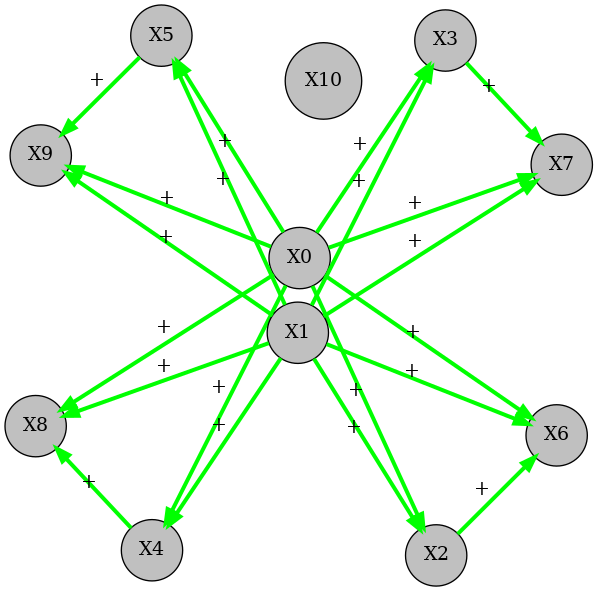

In [4]:
from NORDic.UTILS.utils_plot import influences2graph

influences2graph(influences, save_folder+"example", optional=False, 
                 compile2png=True, engine="sfdp")
from IPython.display import Image
Image(filename=save_folder+'example.png') 

Now that we have built the topology of the network, its dynamics remain to be defined. In that case, we assume that all activators (i.e., regulators connected with an activatory edge) should be active (i.e., an "active" expression level) for the regulated gene to be active.

In [5]:
## Gene regulatory functions (for each node in the network)
grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf = grfs.get(t, [])
    grfs.update(dict([[t, list(set(grf+[s]))]]))

Now, let us write down the corresponding .BNET file *save_folder*/example.bnet

In [6]:
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            network += [g+", "+"&".join(grfs[g])] ## note that the separator is ", "
        else:
            network += [g+", 1"]
    f.write("\n".join(network))
    
## Print the resulting network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([" <- ".join(s.split(", ")) for s in network.split("\n")]))

X0 <- 1
X1 <- 1
X2 <- X1&X0
X3 <- X1&X0
X4 <- X1&X0
X5 <- X1&X0
X6 <- X2&X1&X0
X7 <- X1&X3&X0
X8 <- X1&X4&X0
X9 <- X5&X1&X0
X10 <- 1


### B. Creating random "patient" samples

In **NORDic PMR**, the ability of a given gene to disrupt the expression of the whole network is tested in a specific disease-related transcriptional context, i.e., patient transcriptional profiles ("states"). Since here the nodes in the network are not related to actual genes, we generate 100 binary states at random. Those states should be a dataframe, with samples/patients in columns, genes in rows.

In [7]:
state_len = 200
states = pd.DataFrame(
  [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
  , columns=genes, index=range(state_len)).T
states

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
X0,0,0,0,0,1,0,1,1,1,0,...,0,0,0,1,0,0,0,1,1,1
X1,0,1,0,1,1,0,1,0,0,0,...,0,1,1,0,0,1,1,0,0,1
X2,0,0,1,0,0,1,1,0,0,1,...,1,1,0,1,0,1,0,0,1,0
X3,1,0,0,0,1,0,0,1,1,0,...,0,0,1,0,0,0,1,0,1,0
X4,0,1,1,0,1,1,1,1,1,0,...,0,0,0,0,1,1,0,1,0,0
X5,1,1,1,0,0,1,0,1,0,1,...,1,1,0,1,1,0,0,1,0,0
X6,0,0,0,0,1,0,0,0,1,0,...,0,1,1,0,1,0,0,0,1,0
X7,0,0,1,0,0,0,0,1,0,1,...,1,0,0,1,0,0,1,0,1,1
X8,1,1,0,1,0,0,0,0,0,1,...,1,1,0,0,0,1,1,0,0,1
X9,1,1,1,0,1,0,0,0,1,0,...,1,1,0,0,1,0,1,1,0,1


### C. Selection of parameters

Again, we need to set the random seed for increased reproducibility, and set the maximum number of threads to use:

In [8]:
seed_number=0
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2)) #minimum between all available -2 and 5

In order to prove our conjecture (that X0 and X1 are the most regulatory in this network), we set k to 2, that is, we return all the sets of 2 nodes in the network that *roughly* (see paper) maximize the perturbation of the whole network.

In [9]:
k=2

The perturbation of the network should be computed for each gene in the network (list *gene_inputs*), on every "regulatable" gene (that is, a gene which has at least one regulator which is not itself) (list *genes_outputs*).

In [10]:
## Compute the list of "regulatable" genes from the network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes, # genes to be perturbed
    "gene_outputs": gene_outputs # genes to be observed
}

Let us now set parameters relative to the simulations of trajectories under perturbation of the network (see [mpbn-sim](https://github.com/bnediction/mpbn-sim)):

In [11]:
SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

All in all

In [12]:
seed_number=12345
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2))

k=2

with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
gene_outputs = [ x.split(", ")[0] for x in network.split("\n")[:-1] 
    if (x.split(", ")[1] not in [x.split(", ")[0], "0", "1"])]

IM_params = {
    "seed": seed_number, "gene_inputs": genes,
    "gene_outputs": gene_outputs
}

SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs,
    'depth': "constant_unitary",
}

### D. Detection of master regulators

Function *greedy* implements the approximately optimal greedy algorithm from the following paper

>Kempe, David, Jon Kleinberg, and Éva Tardos. "Maximizing the spread of influence through a social network." Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.

It returns the predicted set of master regulators, along with the *spread values* computed at each step of the algorithm for each node. Spread values are correlated with the ability to disrupt the expression of the network (see paper).

In [13]:
from NORDic.NORDic_PMR.functions import greedy

S, spreads = greedy(save_folder+"example.bnet", k, states, IM_params, SIMU_params, 
                    save_folder=save_folder)

<NORD_PMR> Iteration k=1
	<NORD_PMR> Initial state 3
	<NORD_PMR> Initial state 1
1 wild type attractors (initial state 3)
Gene X0 (1/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 2
1 wild type attractors (initial state 2)
Gene X0 (1/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 4
1 wild type attractors (initial state 1)
Gene X0 (1/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 4)
Gene X0 (1/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 0
Gene X2 (3/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 0)
Gene X0 (1/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13506.14it/s]

Gene X2 (3/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X7 (8/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

 69%|██████▉   | 693/1000 [00:00<00:00, 6926.46it/s]

Gene X10 (11/11) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 5
Gene X10 (11/11) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 5)
Gene X0 (1/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12394.92it/s]

100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]

Gene X8 (9/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 6
Gene X2 (3/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 6)
Gene X8 (9/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]

Gene X10 (11/11) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 7
1 wild type attractors (initial state 7)
Gene X0 (1/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7369.64it/s]

Gene X10 (11/11) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 8
Gene X6 (7/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 8)
Gene X0 (1/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 9



100%|██████████| 1000/1000 [00:00<00:00, 12607.05it/s]

1 wild type attractors (initial state 9)
Gene X0 (1/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 855/1000 [00:00<00:00, 8545.14it/s]

 58%|█████▊    | 585/1000 [00:00<00:00, 5053.42it/s]

Gene X9 (10/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 10


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]t/s]


100%|██████████| 1000/1000 [00:00<00:00, 11389.15it/s]

1 wild type attractors (initial state 10)
Gene X6 (7/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 7121.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9153.83it/s]

Gene X2 (3/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Gene X4 (5/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13805.68it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 11
Gene X7 (8/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 11)
Gene X0 (1/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 12
Gene X8 (9/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 12)
Gene X0 (1/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 13
Gene X1 (2/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 13)
Gene X0 (1/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7639.20it/s]

Gene X10 (11/11) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 14
	<NORD_PMR> Initial state 15
1 wild type attractors (initial state 14)
Gene X2 (3/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 15)
Gene X0 (1/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11886.70it/s]

100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12847.17it/s]

Gene X1 (2/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11595.25it/s]

Gene X5 (6/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 16


100%|██████████| 1000/1000 [00:00<00:00, 12755.78it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12772.33it/s]

Gene X10 (11/11) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 16)
Gene X0 (1/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 17
Gene X10 (11/11) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 17)
Gene X0 (1/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 18



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12715.60it/s]

1 wild type attractors (initial state 18)
Gene X1 (2/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 19
Gene X1 (2/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 19)
Gene X0 (1/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 20
Gene X2 (3/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 20)
Gene X0 (1/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 10191.43it/s]

Gene X4 (5/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12702.58it/s]

Gene X6 (7/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 21
Gene X10 (11/11) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 21)
Gene X0 (1/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20262.34it/s]

Gene X9 (10/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 22
Gene X1 (2/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 23
1 wild type attractors (initial state 22)
Gene X0 (1/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 23)
Gene X0 (1/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1000/1000 [00:00<00:00, 8230.65it/s]

Gene X2 (3/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 24
Gene X3 (4/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 24)
Gene X0 (1/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 25
Gene X4 (5/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11181.17it/s]

1 wild type attractors (initial state 25)
Gene X0 (1/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11818.44it/s]

Gene X2 (3/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 26
Gene X5 (6/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 26)
Gene X0 (1/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13253.82it/s]

	<NORD_PMR> Initial state 27
Gene X6 (7/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 27)
Gene X0 (1/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 23 - consta


100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]

100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13541.50it/s]

Gene X9 (10/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 28
Gene X10 (11/11) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 28)
Gene X0 (1/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29




100%|██████████| 1/1 [00:00<00:00, 11949.58it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12265.59it/s]

Gene X6 (7/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 29)
Gene X0 (1/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 30
Gene X2 (3/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 30)
Gene X0 (1/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]


Gene X2 (3/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 31
Gene X8 (9/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 31)
Gene X0 (1/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6681.14it/s]

100%|██████████| 1/1 [00:00<00:00, 16194.22it/s]

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12605.46it/s]

Gene X9 (10/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

100%|██████████| 1/1 [00:00<00:00, 15033.35it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12334.30it/s]

Gene X6 (7/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 32
Gene X4 (5/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 32)
Gene X0 (1/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14834.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 33
1 wild type attractors (initial state 33)
Gene X0 (1/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 34
	<NORD_PMR> Initial state 35
1 wild type attractors (initial state 34)
Gene X4 (5/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 36
Gene X0 (1/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 35)
Gene X0 (1/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 36)
Gene X0 (1/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 34 - constant_unitary_depth{}	full

100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14147.48it/s]

Gene X1 (2/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

Gene X9 (10/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 37
1 wild type attractors (initial state 37)
Gene X10 (11/11) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 38
Gene X1 (2/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 38)
Gene X0 (1/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 39
Gene X1 (2/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 39)
Gene X0 (1/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

Gene X1 (2/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14465.01it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 40
	<NORD_PMR> Initial state 41
Gene X7 (8/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 40)
Gene X0 (1/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 41)
Gene X0 (1/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]

Gene X5 (6/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 42
1 wild type attractors (initial state 42)
Gene X0 (1/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10353.34it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11996.06it/s]

Gene X5 (6/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16771.04it/s]

	<NORD_PMR> Initial state 43
Gene X4 (5/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 43)
Gene X0 (1/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14976.18it/s]

100%|██████████| 1/1 [00:00<00:00, 16844.59it/s]


Gene X2 (3/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 44


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 44)
Gene X8 (9/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 45
Gene X1 (2/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 45)
Gene X9 (10/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 87%|████████▋ | 866/1000 [00:00<00:00, 8657.61it/s]

Gene X0 (1/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 46
Gene X1 (2/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 47
1 wild type attractors (initial state 46)
Gene X0 (1/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 47)
Gene X0 (1/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 48
Gene X2 (3/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 48)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15252.01it/s]

 88%|████████▊ | 883/1000 [00:00<00:00, 7626.54it/s]

Gene X0 (1/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12879.79it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14193.78it/s]

Gene X2 (3/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 49
Gene X9 (10/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 49)
Gene X0 (1/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 19000.16it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12333.50it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


100%|██████████| 1000/1000 [00:00<00:00, 10700.52it/s]

Gene X5 (6/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 50
Gene X8 (9/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 50)
Gene X0 (1/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9166.35it/s]

Gene X5 (6/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 51
Gene X2 (3/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 51)
Gene X0 (1/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12905.95it/s]

Gene X1 (2/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 52
Gene X9 (10/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 52)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13149.48it/s]

Gene X0 (1/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 53
Gene X10 (11/11) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 53)
Gene X1 (2/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 54
Gene X4 (5/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 54)
Gene X0 (1/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10438.47it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 55
1 wild type attractors (initial state 55)
Gene X0 (1/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

 73%|███████▎  | 731/1000 [00:00<00:00, 7307.45it/s]

Gene X7 (8/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9514.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Gene X9 (10/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 56
Gene X9 (10/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 56)
Gene X10 (11/11) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

 77%|███████▋  | 767/1000 [00:00<00:00, 7666.95it/s]

100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 57
Gene X10 (11/11) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 57)
Gene X8 (9/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 58
Gene X9 (10/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59
Gene X1 (2/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 58)
Gene X0 (1/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 59)
Gene X10 (11/11) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12587.68it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7478.44it/s]

	<NORD_PMR> Initial state 60
1 wild type attractors (initial state 60)
Gene X0 (1/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13185.78it/s]

Gene X7 (8/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 61
	<NORD_PMR> Initial state 62
Gene X9 (10/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 61)
Gene X0 (1/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 62)
Gene X0 (1/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]

100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

Gene X2 (3/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 63
Gene X2 (3/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 63)
Gene X9 (10/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 8435.51it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12067.06it/s]

100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 64
	<NORD_PMR> Initial state 65
Gene X5 (6/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 64)
Gene X0 (1/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13279.71it/s]

Gene X6 (7/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 65)
Gene X0 (1/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8352.38it/s]

100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]


Gene X2 (3/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}



 77%|███████▋  | 773/1000 [00:00<00:00, 7726.05it/s]

	<NORD_PMR> Initial state 66
Gene X9 (10/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 66)
Gene X6 (7/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12124.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 67
Gene X6 (7/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 67)
Gene X0 (1/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11762.79it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14511.81it/s]

Gene X4 (5/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}



 67%|██████▋   | 669/1000 [00:00<00:00, 6359.53it/s]

Gene X6 (7/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 68
1 wild type attractors (initial state 68)
Gene X0 (1/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 69
Gene X9 (10/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 69)
Gene X0 (1/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12033.37it/s]

Gene X10 (11/11) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 70
1 wild type attractors (initial state 70)
Gene X0 (1/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 71
Gene X3 (4/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 71)
Gene X0 (1/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8066.65it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

	<NORD_PMR> Initial state 72
1 wild type attractors (initial state 72)
Gene X0 (1/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 73


100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12502.62it/s]

	<NORD_PMR> Initial state 74
1 wild type attractors (initial state 73)
Gene X0 (1/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 75
Gene X9 (10/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 74)
Gene X0 (1/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 75)
Gene X0 (1/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20560.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16561.00it/s]

Gene X1 (2/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 76
Gene X2 (3/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 76)
Gene X0 (1/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X5 (6/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 77
Gene X7 (8/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 77)
	<NORD_PMR> Initial state 78
Gene X0 (1/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 78)


100%|██████████| 1000/1000 [00:00<00:00, 16092.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X0 (1/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 79
Gene X1 (2/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 79)
Gene X0 (1/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 80
Gene X4 (5/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 80)
Gene X0 (1/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10977.18it/s]

Gene X1 (2/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81
Gene X5 (6/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 81)
Gene X0 (1/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 862/1000 [00:00<00:00, 8618.90it/s]

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 7411.22it/s]

Gene X9 (10/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 82



100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 82)
Gene X0 (1/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 83
1 wild type attractors (initial state 83)
Gene X0 (1/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 84
Gene X7 (8/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7357.76it/s]

Gene X8 (9/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 84)
Gene X0 (1/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 85
Gene X9 (10/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 85)
Gene X0 (1/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 10832.45it/s]

Gene X9 (10/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 86


  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 86)
Gene X0 (1/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 87
Gene X3 (4/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 87)
Gene X0 (1/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X1 (2/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Gene X3 (4/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 88
Gene X6 (7/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 88)
Gene X0 (1/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 805/1000 [00:00<00:00, 8046.67it/s]

Gene X8 (9/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11487.37it/s]

	<NORD_PMR> Initial state 89
Gene X4 (5/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 89)
Gene X8 (9/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 16082.08it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8365.24it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 90
1 wild type attractors (initial state 90)
Gene X0 (1/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 91
Gene X3 (4/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 91)
Gene X1 (2/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 92
Gene X1 (2/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9480.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8298.44it/s]

100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 92)
Gene X0 (1/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 93
Gene X2 (3/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 93)
Gene X0 (1/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9294.90it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8012.93it/s]

Gene X3 (4/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 6183.78it/s]

100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]

 48%|████▊     | 481/1000 [00:00<00:00, 4807.24it/s]

Gene X3 (4/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9172.49it/s]

Gene X5 (6/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 94
Gene X6 (7/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7916.08it/s]

Gene X8 (9/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 94)
Gene X0 (1/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16513.01it/s]

Gene X9 (10/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 95
Gene X9 (10/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 95)
Gene X0 (1/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

 85%|████████▍ | 847/1000 [00:00<00:00, 8469.58it/s]

	<NORD_PMR> Initial state 96
Gene X1 (2/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 96)
Gene X0 (1/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 97
Gene X6 (7/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 97)
Gene X0 (1/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7253.76it/s]

Gene X1 (2/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12855.39it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]


	<NORD_PMR> Initial state 98
1 wild type attractors (initial state 98)
Gene X0 (1/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 99
Gene X8 (9/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 99)
Gene X1 (2/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 100
Gene X3 (4/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 100)
Gene X0 (1/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11366.25it/s]

Gene X8 (9/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 101
Gene X9 (10/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 101)
Gene X0 (1/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]

Gene X6 (7/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 102
1 wild type attractors (initial state 102)
Gene X0 (1/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 103
1 wild type attractors (initial state 103)
Gene X0 (1/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12870.90it/s]

Gene X4 (5/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 104
Gene X5 (6/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 104)
Gene X0 (1/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 684/1000 [00:00<00:00, 6836.03it/s]

Gene X10 (11/11) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6503.71it/s]

100%|██████████| 1/1 [00:00<00:00, 14413.42it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7596.78it/s]

	<NORD_PMR> Initial state 105
Gene X7 (8/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 105)
Gene X0 (1/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10629.90it/s]

Gene X9 (10/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 106
Gene X2 (3/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 106)
Gene X10 (11/11) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 5463.80it/s]

100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9331.60it/s]

	<NORD_PMR> Initial state 107
Gene X4 (5/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 108
Gene X6 (7/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 108)
Gene X0 (1/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 107)
Gene X0 (1/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16119.29it/s]

Gene X1 (2/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 6633.04it/s]

Gene X4 (5/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 109
Gene X5 (6/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

Gene X10 (11/11) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 109)
Gene X0 (1/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 110



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 20253.92it/s]

100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12340.40it/s]

1 wild type attractors (initial state 110)
Gene X0 (1/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▍| 947/1000 [00:00<00:00, 9465.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 111
Gene X8 (9/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 111)
Gene X0 (1/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8600.28it/s]

Gene X8 (9/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 112
Gene X10 (11/11) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 112)
Gene X0 (1/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 17635.06it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12540.34it/s]

Gene X10 (11/11) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 113
Gene X3 (4/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 113)
Gene X0 (1/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 114
Gene X2 (3/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 114)
Gene X0 (1/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11571.45it/s]

Gene X8 (9/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15112.27it/s]

Gene X9 (10/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15017.15it/s]

	<NORD_PMR> Initial state 115
Gene X6 (7/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 115)
Gene X0 (1/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 116
Gene X2 (3/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 116)
Gene X0 (1/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 117
Gene X9 (10/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 117)
Gene X8 (9/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12748.99it/s]

Gene X10 (11/11) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 118
Gene X2 (3/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 118)
Gene X0 (1/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 119
Gene X1 (2/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 119)
Gene X0 (1/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

 70%|███████   | 701/1000 [00:00<00:00, 7006.01it/s]

Gene X4 (5/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9240.81it/s]

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8793.27it/s]

Gene X4 (5/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 120



100%|██████████| 1000/1000 [00:00<00:00, 10995.31it/s]

Gene X5 (6/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 120)
Gene X9 (10/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 121
1 wild type attractors (initial state 121)
Gene X0 (1/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 13573.80it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

Gene X7 (8/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7611.09it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 122
Gene X3 (4/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 122)
Gene X0 (1/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 123
Gene X9 (10/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 123)
Gene X0 (1/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 124
Gene X7 (8/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 124)
Gene X0 (1/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 17752.54it/s]

Gene X8 (9/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 125
Gene X8 (9/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 125)
Gene X0 (1/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 850/1000 [00:00<00:00, 8493.83it/s]

Gene X2 (3/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 126
Gene X7 (8/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 127
1 wild type attractors (initial state 126)
Gene X0 (1/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 127)
Gene X0 (1/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6544.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 128
1 wild type attractors (initial state 128)
Gene X3 (4/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 129
Gene X9 (10/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 129)
Gene X0 (1/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6856.50it/s]

Gene X4 (5/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 130
Gene X7 (8/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 130)
Gene X0 (1/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]


Gene X1 (2/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10715.99it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14369.02it/s]

100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 131
Gene X5 (6/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 131)
	<NORD_PMR> Initial state 132
Gene X0 (1/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 132)
Gene X0 (1/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 8910.33it/s]

Gene X1 (2/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 133



100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 133)
Gene X0 (1/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}



 67%|██████▋   | 671/1000 [00:00<00:00, 5905.59it/s]

Gene X9 (10/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 134


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 134)
Gene X0 (1/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11928.45it/s]

	<NORD_PMR> Initial state 135
Gene X2 (3/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 136
1 wild type attractors (initial state 135)
Gene X0 (1/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 136)
Gene X0 (1/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11295.20it/s]

Gene X1 (2/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 137
Gene X4 (5/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 137)
Gene X0 (1/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

Gene X9 (10/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 138



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 138)
Gene X0 (1/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 139
Gene X6 (7/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 139)
Gene X0 (1/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 140


 97%|█████████▋| 966/1000 [00:00<00:00, 9657.89it/s]

Gene X8 (9/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 141
1 wild type attractors (initial state 140)
Gene X0 (1/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 141)
Gene X0 (1/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 142
Gene X2 (3/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 142)
Gene X0 (1/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14487.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15590.18it/s]

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 91%|█████████ | 908/1000 [00:00<00:00, 9078.67it/s]

Gene X7 (8/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 143



100%|██████████| 1000/1000 [00:00<00:00, 9327.68it/s]

100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


Gene X7 (8/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 143)
Gene X0 (1/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 144
	<NORD_PMR> Initial state 145
Gene X1 (2/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 144)
1 wild type attractors (initial state 145)
Gene X0 (1/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]

 67%|██████▋   | 673/1000 [00:00<00:00, 6728.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X2 (3/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 146
1 wild type attractors (initial state 146)
Gene X0 (1/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15252.01it/s]

Gene X2 (3/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 147
Gene X5 (6/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 147)
Gene X0 (1/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 702/1000 [00:00<00:00, 7017.45it/s]

Gene X4 (5/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13428.78it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]


Gene X6 (7/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

 73%|███████▎  | 730/1000 [00:00<00:00, 7298.23it/s]

Gene X10 (11/11) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 148
Gene X9 (10/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 148)
Gene X0 (1/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 149
1 wild type attractors (initial state 149)
Gene X0 (1/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 150
	<NORD_PMR> Initial state 151
1 wild type attractors (initial state 150)
Gene X0 (1/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13228.57it/s]

100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 151)
Gene X0 (1/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12557.31it/s]

Gene X3 (4/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13464.86it/s]

Gene X7 (8/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 152



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Gene X10 (11/11) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 152)
Gene X0 (1/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 153
Gene X10 (11/11) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 153)
Gene X0 (1/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 154
1 wild type attractors (initial state 154)
Gene X0 (1/11) in state 154 - constant_unitary_depth{}	fully_asyn

 82%|████████▏ | 818/1000 [00:00<00:00, 8175.78it/s]s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 155
1 wild type attractors (initial state 155)
Gene X0 (1/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 156
Gene X3 (4/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 156)
Gene X0 (1/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 153 - co

 85%|████████▍ | 849/1000 [00:00<00:00, 8486.81it/s]

Gene X4 (5/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 15295.68it/s]

100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]


Gene X7 (8/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11049.07it/s]

Gene X6 (7/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 8591.80it/s]]

100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7014.48it/s]


Gene X6 (7/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 157
Gene X10 (11/11) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 158
1 wild type attractors (initial state 157)
Gene X0 (1/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 158)
Gene X0 (1/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6473.94it/s]


100%|██████████| 1/1 [00:00<00:00, 15534.46it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11563.28it/s]

Gene X1 (2/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 159
1 wild type attractors (initial state 159)
Gene X0 (1/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 160
Gene X2 (3/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 160)


  0%|          | 0/1 [00:00<?, ?it/s]

Gene X0 (1/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 161
1 wild type attractors (initial state 161)
Gene X0 (1/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]



Gene X4 (5/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 14571.40it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▎  | 736/1000 [00:00<00:00, 7355.22it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8216.81it/s]

Gene X8 (9/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14691.49it/s]

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

Gene X7 (8/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 162
1 wild type attractors (initial state 162)
Gene X0 (1/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X10 (11/11) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 163
Gene X9 (10/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 163)
Gene X0 (1/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 164
Gene X1 (2/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 164)
Gene X1 (2/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 14176.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15027.96it/s]

Gene X2 (3/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 165
	<NORD_PMR> Initial state 166
1 wild type attractors (initial state 165)
Gene X0 (1/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 166)
Gene X0 (1/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12659.60it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

Gene X7 (8/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12130.65it/s]

100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 167
Gene X5 (6/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 167)
Gene X0 (1/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15087.42it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13694.48it/s]

Gene X9 (10/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15596.67it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 168
Gene X8 (9/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 168)
Gene X9 (10/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9237.68it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 169
	<NORD_PMR> Initial state 170
Gene X5 (6/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 169)
Gene X0 (1/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 171
1 wild type attractors (initial state 170)
Gene X0 (1/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


1 wild type attractors (initial state 171)
Gene X1 (2/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10085.47it/s]

Gene X2 (3/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]t/s]

100%|██████████| 1000/1000 [00:00<00:00, 14401.69it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12993.27it/s]

Gene X5 (6/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 172



 70%|███████   | 702/1000 [00:00<00:00, 7018.63it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

Gene X6 (7/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 172)
Gene X0 (1/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9300.13it/s]

Gene X10 (11/11) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 173
Gene X9 (10/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 173)
Gene X0 (1/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 174
Gene X9 (10/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 174)
Gene X0 (1/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 175
Gene X10 (11/11) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 175)
Gene X0 (1/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 176
Gene X1 (2/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 176)
Gene X0 (1/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10649.33it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (6/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

 64%|██████▍   | 639/1000 [00:00<00:00, 6379.62it/s]

Gene X7 (8/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

Gene X9 (10/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 177
Gene X10 (11/11) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 177)
Gene X0 (1/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 178
Gene X9 (10/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 178)
Gene X0 (1/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (2/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 179
Gene X9 (10/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 179)
Gene X0 (1/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11494.05it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (4/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 180
Gene X3 (4/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 180)
Gene X0 (1/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 181
Gene X3 (4/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 181)
Gene X0 (1/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21399.51it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11808.55it/s]

Gene X5 (6/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11

100%|██████████| 1000/1000 [00:00<00:00, 14139.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]


Gene X8 (9/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 182
Gene X7 (8/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 182)
Gene X0 (1/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19878.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 183
Gene X8 (9/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 183)
Gene X0 (1/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11531.78it/s]

Gene X10 (11/11) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 184
Gene X10 (11/11) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 184)
Gene X0 (1/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 185
	<NORD_PMR> Initial state 186


100%|██████████| 1000/1000 [00:00<00:00, 10736.32it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 186)
Gene X0 (1/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 185)
Gene X0 (1/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12313.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (3/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 187
Gene X3 (4/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 187)
Gene X0 (1/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13867.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8204.85it/s]]

Gene X8 (9/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 188
Gene X6 (7/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 188)
Gene X0 (1/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (9/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Gene X10 (11/11) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 189
Gene X10 (11/11) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 189)
Gene X0 (1/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

	<NORD_PMR> Initial state 190
Gene X7 (8/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 190)
Gene X0 (1/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14084.53it/s]

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (10/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 191
Gene X8 (9/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 191)
Gene X0 (1/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15519.06it/s]

	<NORD_PMR> Initial state 192
Gene X10 (11/11) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 192)
Gene X0 (1/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 193
Gene X5 (6/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 193)
Gene X0 (1/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12930.74it/s]

Gene X3 (4/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 194
Gene X9 (10/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 194)
Gene X5 (6/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X0 (1/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19784.45it/s]

 77%|███████▋  | 767/1000 [00:00<00:00, 7666.32it/s]

Gene X10 (11/11) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 195
Gene X2 (3/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 195)
Gene X0 (1/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (8/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (7/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 196
Gene X8 (9/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 18161.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 196)
Gene X0 (1/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 197
Gene X4 (5/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 197)
Gene X0 (1/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10838.41it/s]

	<NORD_PMR> Initial state 198
1 wild type attractors (initial state 198)
Gene X0 (1/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 199
Gene X5 (6/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 199)
Gene X0 (1/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (2/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 10993.26it/s]

Gene X6 (7/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (3/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (4/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (5/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (5/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (6/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9530.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11419.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (11/11) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (7/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (8/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12959.78it/s]

Gene X9 (10/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (9/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (10/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (11/11) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]

<NORD_PMR> Iteration k=2
	<NORD_PMR> Initial state 0
	<NORD_PMR> Initial state 2
	<NORD_PMR> Initial state 3
	<NORD_PMR> Initial state 1
	<NORD_PMR> Initial state 4
1 wild type attractors (initial state 2)
1 wild type attractors (initial state 0)
Gene X1 (1/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 4)
1 wild type attractors (initial state 3)
Gene X1 (1/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 1)
Gene X1 (1/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16226.43it/s]

Gene X2 (2/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 721/1000 [00:00<00:00, 6881.60it/s]

100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]

100%|██████████| 1/1 [00:00<00:00, 16008.79it/s]

Gene X4 (4/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|███████▉  | 797/1000 [00:00<00:00, 7965.87it/s]

Gene X6 (6/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1000/1000 [00:00<00:00, 8173.31it/s]

100%|██████████| 1/1 [00:00<00:00, 9383.23it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15065.53it/s]

Gene X7 (7/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 17119.82it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 0 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 5
Gene X9 (9/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 6
1 wild type attractors (initial state 5)
Gene X1 (1/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 4 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 6)
Gene X1 (1/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 7
Gene X2 (2/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 8
1 wild type attractors (initial state 7)
Gene X1 (1/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 8)
Gene X1 (1/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 8886.99it/s]

Gene X10 (10/10) in state 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 9
Gene X3 (3/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 7206.71it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 9)
Gene X1 (1/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 14421.30it/s]

Gene X5 (5/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 10
1 wild type attractors (initial state 10)
Gene X1 (1/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 11
Gene X8 (8/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 11)
Gene X1 (1/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 6 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 12
1 wild type attractors (initial state 12)
Gene X1 (1/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 13
Gene X5 (5/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 13)
Gene X1 (1/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 14
Gene X2 (2/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 14)
Gene X6 (6/10) in state 10 - constant_unitary_depth{}	fu

100%|██████████| 1/1 [00:00<00:00, 15534.46it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13703.47it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X1 (1/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13227.36it/s]

Gene X3 (3/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 15
Gene X10 (10/10) in state 11 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 15)
Gene X1 (1/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 16
Gene X9 (9/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 16)
Gene X1 (1/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

Gene X9 (9/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 12 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 13 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 17
Gene X3 (3/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 17)
Gene X10 (10/10) in state 14 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13451.34it/s]

100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]

	<NORD_PMR> Initial state 18
Gene X5 (5/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 18)
Gene X1 (1/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 19
Gene X6 (6/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 19)
Gene X1 (1/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 676/1000 [00:00<00:00, 6758.91it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8589.13it/s]

Gene X2 (2/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7959.71it/s]

Gene X6 (6/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 15 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 16 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 20
	<NORD_PMR> Initial state 21
1 wild type attractors (initial state 20)
Gene X1 (1/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 21)
Gene X1 (1/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14706.17it/s]

Gene X3 (3/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 17 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 18 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 22
Gene X7 (7/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 22)
Gene X8 (8/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12227.97it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8972.35it/s]

Gene X8 (8/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 23
Gene X9 (9/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 19 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 23)
Gene X1 (1/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 20 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]


Gene X3 (3/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 24
	<NORD_PMR> Initial state 25
Gene X2 (2/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 24)
Gene X1 (1/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 25)
Gene X1 (1/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9807.36it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9094.78it/s]

Gene X4 (4/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1/1 [00:00<00:00, 15252.01it/s]it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 21 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 23 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 26
Gene X7 (7/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 26)
Gene X1 (1/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 27
Gene X10 (10/10) in state 22 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 27)
Gene X1 (1/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14210.90it/s]

Gene X8 (8/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 28
Gene X9 (9/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 28)
Gene X1 (1/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 24 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9008.81it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 25 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 29
Gene X3 (3/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 30
Gene X7 (7/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12109.77it/s]

1 wild type attractors (initial state 29)
Gene X1 (1/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 30)
Gene X4 (4/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 8160.73it/s]

Gene X9 (9/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 26 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 27 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 31
Gene X7 (7/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 31)
Gene X1 (1/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 32


  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 32)
Gene X1 (1/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12135.31it/s]

Gene X6 (6/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 28 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 33
Gene X4 (4/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 33)
Gene X1 (1/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 30 - constant_unitary_depth{}	fully_asynchr

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

Gene X10 (10/10) in state 29 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 30 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 31 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 34
	<NORD_PMR> Initial state 35
Gene X4 (4/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 34)
Gene X1 (1/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 35)
Gene X1 (1/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

	<NORD_PMR> Initial state 36
Gene X9 (9/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 36)
Gene X1 (1/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 32 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9352.85it/s]

	<NORD_PMR> Initial state 37
Gene X4 (4/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 37)
Gene X1 (1/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7894.82it/s]

Gene X7 (7/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 33 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Gene X9 (9/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 38
1 wild type attractors (initial state 38)
Gene X1 (1/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 34 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 35 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 36 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 39
Gene X2 (2/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 39)
Gene X1 (1/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 37 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 40
	<NORD_PMR> Initial state 41
Gene X3 (3/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 40)
Gene X2 (2/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]

1 wild type attractors (initial state 41)
Gene X1 (1/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 42
Gene X2 (2/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 42)
Gene X1 (1/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

Gene X4 (4/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11525.50it/s]

Gene X7 (7/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 39 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 40 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 42 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19328.59it/s]

100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]


	<NORD_PMR> Initial state 43
Gene X8 (8/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 44
	<NORD_PMR> Initial state 45
1 wild type attractors (initial state 43)
Gene X1 (1/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 38 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 44)
Gene X1 (1/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 45)
Gene X1 (1/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 46



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

 76%|███████▌  | 756/1000 [00:00<00:00, 7557.75it/s]

Gene X3 (3/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 46)
Gene X1 (1/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 41 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 47
Gene X5 (5/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 47)
Gene X1 (1/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 43 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 44 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 45 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 48
Gene X6 (6/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 49
	<NORD_PMR> Initial state 50
1 wild type attractors (initial state 48)
Gene X1 (1/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 49)
Gene X1 (1/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 50)
Gene X1 (1/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 17467.53it/s]

Gene X9 (9/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 46 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

Gene X7 (7/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 51
Gene X8 (8/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 51)
Gene X1 (1/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 47 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 52
Gene X9 (9/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 52)
Gene X1 (1/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 50 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 48 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]



	<NORD_PMR> Initial state 53
Gene X8 (8/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 54
1 wild type attractors (initial state 53)
Gene X1 (1/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 54)
Gene X1 (1/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9279.15it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Gene X2 (2/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 49 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]


	<NORD_PMR> Initial state 55
Gene X5 (5/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 55)
Gene X1 (1/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 51 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

 69%|██████▉   | 692/1000 [00:00<00:00, 6613.18it/s]

	<NORD_PMR> Initial state 56
Gene X7 (7/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 52 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 56)
Gene X1 (1/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 57
Gene X5 (5/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 57)
Gene X1 (1/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 53 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 58
Gene X10 (10/10) in state 54 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 58)
Gene X1 (1/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15709.00it/s]

  0%|          | 0/1000 [00:00<?, ?it/s] 14767.95it/s]

Gene X4 (4/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 59
Gene X5 (5/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 59)
Gene X2 (2/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 55 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 60
1 wild type attractors (initial state 60)
Gene X1 (1/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 56 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 61
Gene X5 (5/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 61)
Gene X1 (1/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


 82%|████████▏ | 822/1000 [00:00<00:00, 8216.56it/s]

Gene X6 (6/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 57 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]


	<NORD_PMR> Initial state 62
Gene X8 (8/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 62)
Gene X1 (1/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 58 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 63
Gene X8 (8/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 63)
Gene X1 (1/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 19267.68it/s]

Gene X5 (5/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 59 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 60 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 64
Gene X3 (3/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 64)
Gene X7 (7/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8923.86it/s]


Gene X4 (4/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 65
Gene X8 (8/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 61 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 65)
Gene X1 (1/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 62 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 66


100%|██████████| 1000/1000 [00:00<00:00, 15611.88it/s]

Gene X2 (2/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 66)
Gene X4 (4/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 67
Gene X1 (1/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 67)
Gene X1 (1/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]


Gene X2 (2/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 63 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 64

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


  0%|          | 0/1000 [00:00<?, ?it/s].46it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12359.78it/s]

1 wild type attractors (initial state 68)
Gene X1 (1/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 64 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12783.77it/s]


	<NORD_PMR> Initial state 69
Gene X3 (3/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 69)
Gene X1 (1/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7533.62it/s]

100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]

100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

Gene X2 (2/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 67 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 65 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 70
	<NORD_PMR> Initial state 71
1 wild type attractors (initial state 70)


100%|██████████| 1000/1000 [00:00<00:00, 11850.53it/s]

Gene X1 (1/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 71)
Gene X1 (1/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 727/1000 [00:00<00:00, 6455.63it/s]

Gene X10 (10/10) in state 66 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 14731.95it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 72
Gene X5 (5/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 72)
Gene X1 (1/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 68 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X4 (4/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 71 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 73
Gene X8 (8/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 74
1 wild type attractors (initial state 73)
Gene X1 (1/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 74)
Gene X1 (1/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11913.61it/s]

Gene X2 (2/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 70 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 69 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 75


100%|██████████| 1000/1000 [00:00<00:00, 7605.28it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

Gene X7 (7/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 76
1 wild type attractors (initial state 76)
Gene X1 (1/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 75)
Gene X1 (1/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}




  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 72 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 9415.75it/s]

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15094.10it/s]

Gene X5 (5/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 77
Gene X7 (7/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 77)
Gene X6 (6/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15831.15it/s]

Gene X6 (6/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 73 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

100%|██████████| 1000/1000 [00:00<00:00, 20113.48it/s]


	<NORD_PMR> Initial state 78
Gene X4 (4/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 78)
Gene X1 (1/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 76 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 8730.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15702.12it/s]

Gene X2 (2/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 75 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 79
1 wild type attractors (initial state 79)
Gene X3 (3/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13964.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 17500.26it/s]

100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 74 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 80
Gene X4 (4/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 80)
Gene X2 (2/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 77 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 81
	<NORD_PMR> Initial state 82
Gene X2 (2/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 81)



 66%|██████▌   | 657/1000 [00:00<00:00, 6569.08it/s]

1 wild type attractors (initial state 82)
Gene X1 (1/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9119.48it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8630.98it/s]

Gene X7 (7/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 78 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 83
Gene X9 (9/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 83)
Gene X1 (1/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]

100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13493.32it/s]

Gene X7 (7/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 82 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 84
1 wild type attractors (initial state 84)
Gene X1 (1/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 79 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 81 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|████████▉ | 898/1000 [00:00<00:00, 8975.99it/s]


	<NORD_PMR> Initial state 85
Gene X6 (6/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 80 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 86
Gene X5 (5/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 85)
Gene X1 (1/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 86)
Gene X1 (1/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 87
Gene X6 (6/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 87)
Gene X1 (1/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12498.60it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12972.65it/s]

100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]1it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14106.61it/s]

Gene X7 (7/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X4 (4/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 83 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 84 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 88
Gene X5 (5/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 89
Gene X4 (4/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 88)
Gene X1 (1/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 89)
Gene X1 (1/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 15542.75it/s]

Gene X4 (4/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 17576.45it/s]

Gene X10 (10/10) in state 86 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 85 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 90
Gene X9 (9/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 90)
Gene X1 (1/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11923.36it/s]

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]


Gene X9 (9/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 88 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 91
Gene X10 (10/10) in state 87 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 89 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 91)
Gene X1 (1/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 92
Gene X3 (3/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 92)
Gene X1 (1/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


	<NORD_PMR> Initial state 93
Gene X4 (4/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 94
1 wild type attractors (initial state 93)
Gene X1 (1/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 94)
Gene X1 (1/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13718.13it/s]

Gene X4 (4/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12730.15it/s]

100%|██████████| 1/1 [00:00<00:00, 15827.56it/s]


Gene X7 (7/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 90 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 95


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10348.61it/s]

1 wild type attractors (initial state 95)
Gene X1 (1/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 91 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 92 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|███████▉  | 799/1000 [00:00<00:00, 7985.80it/s]

	<NORD_PMR> Initial state 96
1 wild type attractors (initial state 96)
	<NORD_PMR> Initial state 97
Gene X1 (1/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 97)
Gene X10 (10/10) in state 94 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 93 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10220.66it/s]

100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]

100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

	<NORD_PMR> Initial state 98
1 wild type attractors (initial state 98)
Gene X1 (1/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 99
Gene X4 (4/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 99)
Gene X1 (1/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12797.58it/s]

 83%|████████▎ | 826/1000 [00:00<00:00, 8255.93it/s]

Gene X7 (7/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15477.14it/s]

100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]

Gene X9 (9/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 96 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 100



 71%|███████   | 707/1000 [00:00<00:00, 6717.83it/s]

Gene X9 (9/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 100)
Gene X1 (1/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 95 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 759/1000 [00:00<00:00, 7589.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 101
Gene X10 (10/10) in state 97 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 101)
Gene X1 (1/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 98 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 9000.59it/s]

 67%|██████▋   | 668/1000 [00:00<00:00, 6676.03it/s]

Gene X3 (3/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 102
Gene X2 (2/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 103
1 wild type attractors (initial state 102)
Gene X1 (1/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 103)
Gene X1 (1/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 8442.40it/s]

Gene X3 (3/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 99 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 104
Gene X7 (7/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 13038.14it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 104)
Gene X1 (1/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 100 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 105


100%|██████████| 1000/1000 [00:00<00:00, 10654.64it/s]

 63%|██████▎   | 628/1000 [00:00<00:00, 6175.35it/s]

1 wild type attractors (initial state 105)
Gene X1 (1/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 103 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 102 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 5930.92it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6270.90it/s]

100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

Gene X4 (4/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 106
	<NORD_PMR> Initial state 107
Gene X7 (7/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 101 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 107)
Gene X1 (1/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 106)
Gene X1 (1/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 108



 79%|███████▊  | 787/1000 [00:00<00:00, 7868.17it/s]

1 wild type attractors (initial state 108)
Gene X1 (1/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 104 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 109
Gene X3 (3/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 105 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 109)
Gene X1 (1/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 110
Gene X2 (2/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 110)
Gene X1 (1/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6583.03it/s]

Gene X4 (4/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1/1 [00:00<00:00, 18641.35it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 107 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 108 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 111
	<NORD_PMR> Initial state 112
Gene X7 (7/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 111)
Gene X1 (1/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 112)
Gene X1 (1/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12264.01it/s]


Gene X9 (9/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 109 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 110 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▎  | 737/1000 [00:00<00:00, 6805.52it/s]

Gene X9 (9/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 113
Gene X4 (4/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 114
1 wild type attractors (initial state 113)
Gene X1 (1/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 114)
Gene X5 (5/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 106 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6690.86it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16652.06it/s]

Gene X6 (6/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 115
Gene X4 (4/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 115)
Gene X1 (1/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 111 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 116
Gene X4 (4/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 116)
Gene X1 (1/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

Gene X8 (8/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 112 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 117
1 wild type attractors (initial state 117)
Gene X3 (3/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14704.06it/s]

Gene X4 (4/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 113 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 118
Gene X4 (4/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 118)
Gene X1 (1/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 779/1000 [00:00<00:00, 7784.87it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14225.41it/s]

Gene X5 (5/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 114 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 119
Gene X7 (7/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 119)
Gene X1 (1/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X7 (7/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13933.08it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14059.94it/s]

Gene X9 (9/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 115 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 116 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 10828.93it/s]

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

	<NORD_PMR> Initial state 120
	<NORD_PMR> Initial state 121
1 wild type attractors (initial state 121)
Gene X1 (1/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 120)
Gene X1 (1/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 117 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14041.67it/s]

Gene X3 (3/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 118 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 122
1 wild type attractors (initial state 122)
Gene X1 (1/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 123
Gene X3 (3/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 123)
Gene X10 (10/10) in state 119 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 124
Gene X4 (4/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 124)
Gene X1 (1/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]

 79%|███████▊  | 786/1000 [00:00<00:00, 7854.78it/s]

Gene X2 (2/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9856.38it/s]

100%|██████████| 1/1 [00:00<00:00, 15252.01it/s]

100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 122 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13034.78it/s]

Gene X6 (6/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 125
Gene X7 (7/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 125)
Gene X1 (1/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]

100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


Gene X9 (9/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 121 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 120 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 123 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 126
Gene X10 (10/10) in state 124 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 128
	<NORD_PMR> Initial state 127
1 wild type attractors (initial state 126)
Gene X1 (1/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 128)
Gene X1 (1/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 129
1 wild type attractors (initial state 127)
Gene X5 (5/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 129)
Gene X1 (1/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 126 - constant_unitary_dep

100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7945.92it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 884/1000 [00:00<00:00, 8836.62it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 766/1000 [00:00<00:00, 7658.05it/s]]]

100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

Gene X6 (6/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12226.69it/s]

Gene X7 (7/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 125 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 130



100%|██████████| 1/1 [00:00<00:00, 15252.01it/s]

 78%|███████▊  | 785/1000 [00:00<00:00, 7401.80it/s]

100%|██████████| 1/1 [00:00<00:00, 13443.28it/s]

1 wild type attractors (initial state 130)
Gene X1 (1/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 126 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 129 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 131
	<NORD_PMR> Initial state 132
Gene X10 (10/10) in state 128 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 131)
Gene X1 (1/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 6916.77it/s]

1 wild type attractors (initial state 132)
Gene X1 (1/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 127 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 133
1 wild type attractors (initial state 133)
Gene X1 (1/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 134
Gene X3 (3/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 134)
Gene X1 (1/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7340.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13711.09it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14209.45it/s]

Gene X5 (5/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|████████▉ | 896/1000 [00:00<00:00, 8889.12it/s]

100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6972.29it/s]

Gene X7 (7/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 131 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 135
Gene X8 (8/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 6280.30it/s]

100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12862.89it/s]

Gene X7 (7/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 135)
Gene X1 (1/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 132 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 134 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 136
Gene X2 (2/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 130 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 136)
Gene X1 (1/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 137
	<NORD_PMR> Initial state 138
1 wild type attractors (initial state 137)
Gene X1 (1/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 138)
Gene X1 (1/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Gene X4 (4/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 133 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 139
Gene X2 (2/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 139)
Gene X1 (1/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 12686.29it/s]

 81%|████████  | 809/1000 [00:00<00:00, 8086.50it/s]

Gene X6 (6/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

Gene X6 (6/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10961.37it/s]

Gene X10 (10/10) in state 135 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 140
Gene X10 (10/10) in state 137 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 140)
Gene X1 (1/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12391.81it/s]

Gene X8 (8/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 141
Gene X9 (9/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 141)
Gene X1 (1/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11981.60it/s]

100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]


Gene X10 (10/10) in state 138 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 136 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 139 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 142
	<NORD_PMR> Initial state 143
Gene X5 (5/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 142)
Gene X1 (1/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 143)
Gene X1 (1/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15544.48it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15278.18it/s]

Gene X4 (4/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 144
Gene X6 (6/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 144)
Gene X1 (1/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 15515.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 140 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19328.59it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 145
Gene X5 (5/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 145)
Gene X5 (5/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 15753.79it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 141 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 146
Gene X3 (3/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 146)
Gene X1 (1/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]


 86%|████████▌ | 858/1000 [00:00<00:00, 8574.63it/s]

Gene X8 (8/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 142 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 144 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 143 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 147
Gene X6 (6/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 148
1 wild type attractors (initial state 147)
Gene X1 (1/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 149
Gene X9 (9/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 148)
Gene X1 (1/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 149)
Gene X1 (1/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 14975.32it/s]

100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8731.28it/s]

Gene X2 (2/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 145 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 6439.34it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 150
1 wild type attractors (initial state 150)
Gene X1 (1/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 146 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 151
1 wild type attractors (initial state 151)
Gene X1 (1/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 6937.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 17729.58it/s]

Gene X3 (3/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15676.24it/s]

100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X4 (4/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Gene X7 (7/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6497.63it/s]

Gene X10 (10/10) in state 150 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 149 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 151 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 152
Gene X10 (10/10) in state 148 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 152)
Gene X1 (1/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 153
1 wild type attractors (initial state 153)
Gene X1 (1/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19878.22it/s]

	<NORD_PMR> Initial state 154
Gene X2 (2/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 147 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 155
1 wild type attractors (initial state 154)
Gene X2 (2/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 155)
Gene X1 (1/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 156
Gene X3 (3/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

1 wild type attractors (initial state 156)
Gene X1 (1/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

 94%|█████████▍| 938/1000 [00:00<00:00, 9377.91it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11343.22it/s]

Gene X5 (5/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 152 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 157
1 wild type attractors (initial state 157)
Gene X1 (1/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 11855.05it/s]

Gene X10 (10/10) in state 153 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 158
Gene X7 (7/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 158)
Gene X3 (3/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 11668.70it/s]

100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8305.50it/s]

 65%|██████▍   | 647/1000 [00:00<00:00, 6468.11it/s]

Gene X2 (2/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X9 (9/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 156 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 155 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 159
1 wild type attractors (initial state 159)
Gene X7 (7/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 154 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 160


100%|██████████| 1000/1000 [00:00<00:00, 14463.42it/s]

Gene X9 (9/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 160)
Gene X1 (1/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 161
Gene X2 (2/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 161)
Gene X10 (10/10) in state 157 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 162



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X4 (4/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 158 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 162)
Gene X2 (2/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 163
Gene X5 (5/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 163)
Gene X1 (1/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 161 - constant_unitary_depth{}	fully_a

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 159 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 160 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11894.89it/s]


	<NORD_PMR> Initial state 164
Gene X6 (6/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 164)
Gene X1 (1/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 165
Gene X5 (5/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 165)
Gene X1 (1/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9329.74it/s]

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Gene X3 (3/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 16336.71it/s]

Gene X8 (8/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 161 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 162 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 163 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14749.82it/s]

	<NORD_PMR> Initial state 166
Gene X8 (8/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 167
Gene X8 (8/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 166)
Gene X1 (1/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 168
1 wild type attractors (initial state 167)
Gene X1 (1/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 165 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 168)
Gene X1 (1/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 165 - constant_un


100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15417.34it/s]

Gene X10 (10/10) in state 164 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 169
	<NORD_PMR> Initial state 170
Gene X4 (4/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 169)
Gene X1 (1/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 170)
Gene X1 (1/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 167 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_PMR> Initial state 171
Gene X6 (6/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 171)
Gene X1 (1/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 166 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 172


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14531.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


Gene X9 (9/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 172)
Gene X3 (3/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 169 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 170 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 168 - constant_unitary_dept

  0%|          | 0/1000 [00:00<?, ?it/s]

 84%|████████▍ | 844/1000 [00:00<00:00, 8434.90it/s]

Gene X3 (3/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 173
Gene X6 (6/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 173)
Gene X1 (1/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 174
1 wild type attractors (initial state 174)
Gene X1 (1/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 168 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 15277.40it/s]

Gene X7 (7/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 175
Gene X2 (2/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 175)
Gene X1 (1/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10781.19it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 171 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 8157.22it/s]

	<NORD_PMR> Initial state 176
Gene X6 (6/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 176)
Gene X1 (1/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X2 (2/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 172 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 177
Gene X6 (6/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X10 (10/10) in state 174 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 177)
Gene X1 (1/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 173 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 178
	<NORD_PMR> Initial state 179
Gene X8 (8/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 178)



100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1 wild type attractors (initial state 179)
Gene X1 (1/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 175 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 180
Gene X8 (8/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 180)
Gene X1 (1/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 7433.63it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16807.87it/s]

Gene X3 (3/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 176 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 177 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 181


100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

100%|██████████| 1000/1000 [00:00<00:00, 14165.45it/s]

Gene X8 (8/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 182
1 wild type attractors (initial state 181)
Gene X5 (5/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 182)
Gene X1 (1/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 179 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 179 - constant_unitary_depth{}	fully_a


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 183
Gene X4 (4/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 183)
Gene X1 (1/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

Gene X9 (9/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 180 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 178 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 184
Gene X4 (4/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

100%|██████████| 1000/1000 [00:00<00:00, 13529.10it/s]

	<NORD_PMR> Initial state 185
Gene X7 (7/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 185)
Gene X1 (1/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 184)
Gene X1 (1/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 17441.09it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X3 (3/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 182 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 181 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 186
Gene X8 (8/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 187



100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12734.63it/s]

100%|██████████| 1/1 [00:00<00:00, 19328.59it/s]

 82%|████████▏ | 823/1000 [00:00<00:00, 8227.32it/s]

1 wild type attractors (initial state 186)
Gene X1 (1/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 187)
Gene X6 (6/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X1 (1/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 183 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

Gene X2 (2/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 188
Gene X7 (7/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 185 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 188)
Gene X1 (1/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 14967.26it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 189
1 wild type attractors (initial state 189)
Gene X1 (1/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 184 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Gene X3 (3/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 190
Gene X4 (4/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 190)
Gene X1 (1/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

Gene X2 (2/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

Gene X9 (9/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 186 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 187 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

Gene X7 (7/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 189 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 191
	<NORD_PMR> Initial state 193
Gene X10 (10/10) in state 188 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 192
1 wild type attractors (initial state 193)
Gene X1 (1/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 191)
Gene X1 (1/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 192)
Gene X1 (1/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]

	<NORD_PMR> Initial state 194
Gene X2 (2/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 190 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 194)
Gene X1 (1/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 195


100%|██████████| 1000/1000 [00:00<00:00, 12972.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6954.14it/s]]

Gene X4 (4/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 195)
Gene X1 (1/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1000/1000 [00:00<00:00, 7351.99it/s]

Gene X4 (4/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 15355.20it/s]

100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X6 (6/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 193 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 9287.10it/s]

Gene X7 (7/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 196
Gene X8 (8/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 196)
Gene X1 (1/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 194 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 15768.06it/s]

100%|██████████| 1000/1000 [00:00<00:00, 11464.80it/s]

100%|██████████| 1000/1000 [00:00<00:00, 12572.25it/s]

Gene X2 (2/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 192 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 197
Gene X10 (10/10) in state 191 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 195 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 197)
Gene X1 (1/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state 198
Gene X3 (3/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors (initial state 198)
Gene X1 (1/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13779.51it/s]

100%|██████████| 1000/1000 [00:00<00:00, 17711.98it/s]

	<NORD_PMR> Initial state 199
1 wild type attractors (initial state 199)
Gene X1 (1/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X2 (2/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X3 (3/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X5 (5/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X4 (4/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X5 (5/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10704.81it/s]

Gene X6 (6/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X6 (6/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X8 (8/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 12154.83it/s]

Gene X8 (8/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X7 (7/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 199 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 196 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 198 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1000 [00:00<?, ?it/s]

Gene X8 (8/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X9 (9/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene X10 (10/10) in state 197 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 13473.60it/s]

### E. Checking out the results

Let us find out if X0 and X1 are indeed the most regulatory in the network. In resulting set S, nodes are contained in the same bin if they yield a similar spread value. Then, we need to unfold the nested list S:

In [14]:
unfoldS = [x for s in S for x in s]
assert all([s in ["X0","X1"] for s in unfoldS])

So, indeed, the conjecture checks out. Now, let us have a look at the spread values:

In [15]:
spreads

,[['X0']],"[['X0'], ['X1']]"
X0,0.404445,NaN
X1,0.370783,0.641483
X2,0.064060,0.451151
X3,0.064060,0.452121
X4,0.073336,0.456004
X5,0.073336,0.452121
X6,0.000000,0.404445
X7,0.000000,0.404445
X8,0.000000,0.404445
X9,0.000000,0.404445


Genes are in rows, the current set of master regulators (for i=1, 2, ..., k) is shown in columns. 

- The first column corresponds to spread values computed when perturbing the set {g} of genes, where g is the gene shown in rows. X0 is the only maximizer of the spread value for i=1, so the current set of master regulators at i=1 is [X0].

- The second column corresponds to spread values computed when perturbing the set {g, X0} of genes, where g is the gene shown in rows. Note that the presence of the NaN is due to the fact that we have already tested X0 alone in the previous step. X1 is the only maximizer of the spread value for i=2, so the current set of master regulators at i=2 is [X0, X1].

- Since we have reached i=2=k, the algorithm stops, and returns [X0, X1].